# This notebook performs Data Process of the Cleaned Data for Model Training




## Load Modules

In [364]:
import os
import random
import time

# Supress Warnings
import warnings

warnings.filterwarnings("ignore")

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.3f" % x)

import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# ANN modeling libraries
import tensorflow as tf
from tensorflow import keras
from keras import backend   # Abstraction layer for neural network backend engines.
from keras.models import Sequential  # Model for building NN sequentially.
from keras.layers import Dense, Dropout  # for creating fully connected neural network lay
from keras import metrics
from keras.losses import BinaryCrossentropy


# Libraries for keras model visualization
import visualkeras
from PIL import ImageFont
from keras_visualizer import visualizer

## Grab Environment Variables 

In [365]:
# Load environment variables from .env
load_dotenv()

True

In [366]:
# Get RAW csv data
CLEAN_DATA_PATH = os.environ.get("CLEAN_DATA_PATH")

--

## Utility Functions

Functions to help evaluate models

--

In [367]:
def make_confusion_matrix(actual_targets: npt.ArrayLike , predicted_targets: npt.ArrayLike) -> sns.axisgrid.FacetGrid | None:
    """To plot the confusion_matrix with percentages

    Args:
        actual_targets (npt.ArrayLike): actual target (dependent) variable values
        predicted_targets (npt.ArrayLike): predicted target (dependent) variable values

    Returns:
        (sns.axisgrid.FacetGrid | None:): a confusion matrix heatmap
    """
    categories = ["Non-churn Customer", "Churn Customer"]
    
    cm = confusion_matrix(actual_targets, predicted_targets)

    group_names = ["True Positive", "False Negative", "False Positive", "True Negative"]

    group_labels = ["{}\n".format(value) for value in group_names]
    group_counts = ["{0:0.0f}\n".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]

    box_labels = [
        f"{v1}{v2}{v3}".strip()
        for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cm.shape[0], cm.shape[1])

    # labels = np.asarray(
    #     [
    #         ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
    #         for item in cm.flatten()
    #     ]
    # ).reshape(cm.shape[0], cm.shape[1])


    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=box_labels, fmt="", cmap="Blues", xticklabels=categories, yticklabels=categories)
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")



### Load the Cleaned Dataset into Pandas DataFame 

In [368]:
df = pd.read_csv(CLEAN_DATA_PATH)

--

# Train, Validation, and Test Splits of the Data

-

In [369]:
# Independent variables - feature matrices
X = df.drop(["exited"], axis=1)

In [370]:
# Target / label
y = df["exited"]

In [371]:
# Splitting the dataset into the Training and Testing set.
X_large, X_test, y_large, y_test = train_test_split(X, y, test_size = 1-(5/6), random_state = 42, stratify=y, shuffle = True)

In [372]:
# Splitting the dataset into the Training and Testing set.
X_train, X_val, y_train, y_val = train_test_split(X_large, y_large, test_size = 1-(5/6), random_state = 42,stratify=y_large, shuffle = True)

In [373]:
print(X_train.shape, X_val.shape, X_test.shape)

(6944, 10) (1389, 10) (1667, 10)


In [374]:
print(y_train.shape, y_val.shape, y_test.shape)

(6944,) (1389,) (1667,)


### Make sure to Prevent Data leakage
From [Data Leakage in Machine Learning and How to Prevent It](https://www.linkedin.com/pulse/data-leakage-machine-learning-how-prevent-karen-wong-jk4yc). I wanted to include this background information as often times we data scientist are in a hurry to split data without making considerations for leakage. 

`Data leakage` occurs when a model accidentally uses information during training that it shouldn’t have access to when making predictions in the real world. This leads to overly optimistic performance during testing but poor results in practice, like a student cheating on a practice exam but failing the real one.

#### Types of Data Leakage

##### Target Leakage

* **What Happens?** 
The model uses features that are only available after the target (prediction) is known.

* **Example:** 
A hospital builds a model to predict diabetes, using a feature like "insulin treatment." But insulin is only prescribed after a diabetes diagnosis. The model "cheats" by using this post-diagnosis data.

* **Solution:** Remove features that are influenced by or created after the target. Use domain knowledge to filter them out.

##### Train-Test Contamination

* **What Happens?** 
Test data "leaks" into the training process, making the model overfit.

* **Example:** 
Normalizing (scaling) a dataset `before` splitting into train/test sets. The test data’s distribution influences the training, leading to false confidence.

* **Solution:** 
**Always split data first** into train/test sets. Preprocess (e.g., scale) using only training data statistics.


##### Preprocessing Leakage

* **What Happens?** 
Steps like imputation or encoding use information from the entire dataset (including test data).

* **Example:** 
Filling missing values with the global mean of a feature (calculated from both train and test data).

* **Solution:** 
Use pipelines: compute means/medians from the **training set only**, then apply them to the test set.


### Dummy Variable Creation Now - Avoids Leakage

In [375]:
# Encoding Geography variables and Gender
X_train = pd.get_dummies(X_train, columns=["geography","gender"],drop_first=True)
X_test = pd.get_dummies(X_test, columns=["geography","gender"],drop_first=True)   ## Complete the code to encode Geography and Gender in test set
X_val = pd.get_dummies(X_val, columns=["geography","gender"],drop_first=True)

### Data Normalization Scaling Now - Avoids Leakage

Normalization is necessary for columns like "CreditScore," "Age," "Tenure," "Balance," and "EstimatedSalary" because they exhibit varying scales and ranges of values.

**credit_score:** Ranges from 350 to 850.

**age:** Ranges from 18 to 92.

**tenure:** Ranges from 0 to 10.

**balance:** Ranges from 0 to 250,898.09.

**estimated_salary:** Ranges from 11.58 to 199,992.48.

These ranges demonstrate the significant differences in scales across the feature columns, highlighting the need for normalization to ensure fair and effective learning in the model.

In [376]:
# defining the list of columns to normalize
cols_list = ["credit_score","age","tenure","balance","estimated_salary"]

# creating an instance of the standard scaler
sc = StandardScaler()

X_train[cols_list] = sc.fit_transform(X_train[cols_list])
X_val[cols_list] = sc.transform(X_val[cols_list])
X_test[cols_list] = sc.transform(X_test[cols_list])

---
---
---

# Building the Models

These models are meant to predict whether or not an existing customer will leave the bank, i.e., is likely to churn. We are are looking for a probability of churning, so the problem fits a binary classification problem where given an appropriate threshold, a customer can be predicted to churn or not. 


## MODELS TO BUILD

* Model with Adam optimizer

* Model with Adam optimizer and Dropout
    - Dropout in neural networks is a regularization technique used to prevent overfitting by randomly turning off a fraction of the neurons during training.

* Model with balanced data by applying SMOTE and SGD optimizer
    - Synthetic Minority Over-sampling TechniquE (SMOTE), is a method used in machine learning to address class imbalance in datasets. It works by generating synthetic samples for the `minority class` to create a more balanced dataset, which can improve the performance of machine learning models.
    - Stochastic Gradient Descent (SGD), is an optimization algorithm used in neural networks to minimize the loss function by updating model parameters based on a small subset of data points at each iteration.


* Model with balanced data by applying SMOTE and Adam optimizer
    - AdAptive Moment Estimation (Adam) is an optimization algorithm used in training neural networks.

* Model with balanced data by applying SMOTE, Adam optimizer, and Dropout

### Model Evaluation Criterion

The potential consequences of model errors include:

**False Positive:** Predicting a customer will churn when they actually don't, leading to unnecessary retention efforts and potentially alienating the customer.

**False Negative:** Failing to predict churn for a customer who actually churns, resulting in loss of revenue and potential damage to the bank's reputation.

Attempting to retain a customer that will does churn serves to build goodwill and costs very little.  Failing to anticipate that a customer will churn and failing to do something to retain them is expensive. Equally expensive is having to acquire new customers to replace the churned customers. 

**False Negatives have a greater impact.**

To mitigate the risk of false negatives, the bank should aim to maximize **recall**

* **Recall = TPR = TruePositive /(TruePositive + TrueNegative) -- (Sensitivity):**

    - Measures the ability of the model to identify all positive instances, i.e., the ratio of true positives to the total number of actual positives.

Higher recall means minimizing false negatives, which can be achieved by optimizing the model to capture as many true churn cases as possible. Hence, the focus should be on increasing recall or minimizing false negatives.


* **Precision = TruePositive /(TruePositive + FalsePostive):**

    - Measures the accuracy of positive predictions, i.e., the ratio of true positives to the total number of predicted positives.

---
---
---

In [377]:
# Model Parameters
batch_size = 32
epochs = 50

#### Let's create two blank dataframes that will store the recall values for all the models we build.

In [378]:
train_metric_df = pd.DataFrame(columns=["recall"])
valid_metric_df = pd.DataFrame(columns=["recall"])

--

## Model - Neural Network with SGD 

This first model is the most simplistic of the proposed models.

It has input, output, and a single hidden layer. 

It uses a stochastic gradient descent optimizer and a minimal number of nodes. 

Post trainng on the data, I will use Area Under the Receiver-Operating Characteris (ROC) Curve (AUC) to find the best threshold with this model.

In [379]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [380]:
#Initializing the neural network
model_0 = Sequential()
# Adding the input layer with 64 neurons and relu as activation function
model_0.add(Dense(64, activation='relu', input_dim = X_train.shape[1]))
# Complete the code to add a hidden layer (specify the # of neurons and the activation function)
model_0.add(Dense(64,activation="tanh"))
# Complete the code to add the output layer with the number of neurons required.
model_0.add(Dense(1, activation = 'sigmoid'))

In [381]:
#Complete the code to use SGD as the optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

# uncomment one of the following lines to define the metric to be used
# metric = 'accuracy'
metric = keras.metrics.Recall()
# metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

In [382]:
## Complete the code to compile the model with binary cross entropy as loss function and recall as the metric.
model_0.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[metric])

In [383]:
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

In [384]:
# Fitting the ANN
start = time.time()
history_0 = model_0.fit(
    X_train, y_train,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    verbose=1
)
end=time.time()

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 0.6228 - recall: 0.1372 - val_loss: 0.5561 - val_recall: 0.0000e+00
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.5264 - recall: 0.0000e+00 - val_loss: 0.5076 - val_recall: 0.0000e+00
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 0.4965 - recall: 0.0000e+00 - val_loss: 0.4908 - val_recall: 0.0000e+00
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.4843 - recall: 0.0000e+00 - val_loss: 0.4831 - val_recall: 0.0000e+00
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.4776 - recall: 0.0000e+00 - val_loss: 0.4787 - val_recall: 0.0000e+00
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 0.4731 - recall: 0.0000e+00 - val_loss: 0.4754 - val_recall: 0.0000e+00
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.4694 - recall: 0.0000e+00 - val_loss: 0.4728 - val_recall: 0.0000e+00
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.46

In [385]:
print("Time taken in seconds ",end-start)

Time taken in seconds  4.532802104949951


In [386]:
history_0.history.keys()

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])

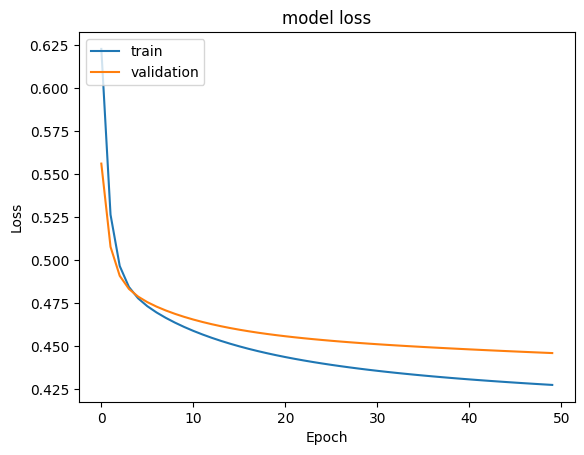

In [387]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Observations

The results are okay for a very basic model that trains quickly. The training and validation track, but the gap beween train and validation is a telltale sign, that this model is not sufficient. 

Lets

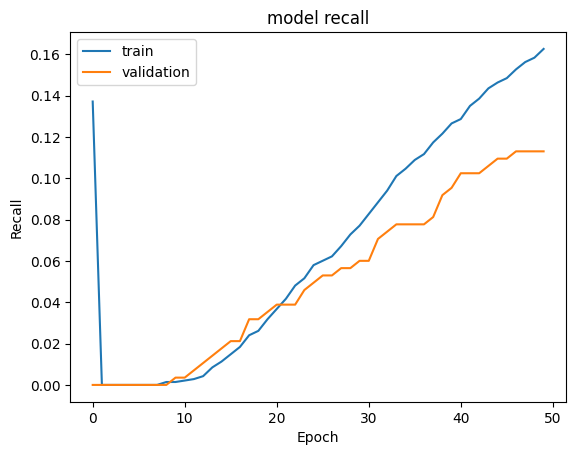

In [388]:
#Plotting Train recall vs Validation recall
plt.plot(history_0.history['recall'])
plt.plot(history_0.history['val_recall'])
plt.title('model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [389]:
#Predicting the results using 0.5 as the default threshold
y_train_pred = model_0.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(6944, 1))

In [390]:
#Predicting the results using best as a threshold
y_val_pred = model_0.predict(X_val)    ## Complete the code to make prediction on the validation set
y_val_pred = (y_val_pred > 0.5)
y_val_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(1389, 1))

In [391]:
#Predicting the results using best as a threshold
y_test_pred = model_0.predict(X_test)    ## Complete the code to make prediction on the validation set
y_test_pred = (y_test_pred > 0.5)
y_test_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [False]], shape=(1667, 1))

In [392]:
model_name = "NN with SGD"

train_metric_df.loc[model_name] = recall_score(y_train, y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val, y_val_pred)

In [393]:
#classification report - Train
cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5530
           1       0.60      0.17      0.26      1414

    accuracy                           0.81      6944
   macro avg       0.71      0.57      0.58      6944
weighted avg       0.77      0.81      0.76      6944



In [394]:
#classification report
cr=classification_report(y_val, y_val_pred)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1106
           1       0.46      0.11      0.18       283

    accuracy                           0.79      1389
   macro avg       0.64      0.54      0.53      1389
weighted avg       0.74      0.79      0.74      1389



In [395]:
#classification report
cr=classification_report(y_test, y_test_pred)    ## Complete the code to check the model's performance on the test set
print(cr)

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1327
           1       0.44      0.11      0.17       340

    accuracy                           0.79      1667
   macro avg       0.62      0.54      0.53      1667
weighted avg       0.73      0.79      0.74      1667



#### Observation of Classification Report

* The accuracy is especially very good
* the recall scores are poor
* the F1-Score for the target class is all poor.

In short, predicting churning customers for this model is not very good.

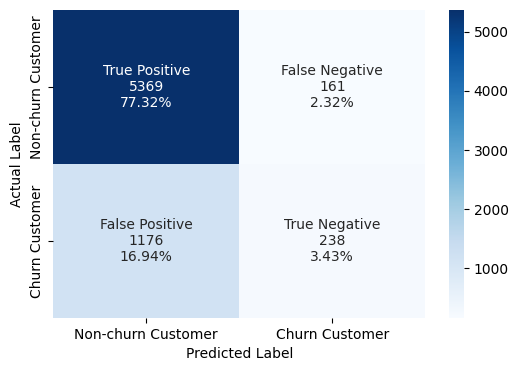

In [396]:
# Calculating the confusion matrix
make_confusion_matrix(y_train, y_train_pred)

That's not a bad False Negative rate.

The dataset is imbalanced, and we'll experiment later with balancing the data. But we're also using a default threshold, and we should try calculating a more useful threshold with an AUC-ROC curve.

### Tuning the threshold parameter `y_val_pred` using AUC ROC Curve

Note, I use the geometric mean:

* True Postitive Rate (TPR)
    * True Positive (TP)
    * False Negative (FN)

        $\frac{TP}{TP + FN}$


* False Postitive Rate (FPR)
    * True Negative (TN)
    * False Positive (FP)

        $\frac{FP}{TN + FP}$

* Identify TPR and FPR at different threshold (y_val_pred) values
* Calculate Specificity: **Specificity = 1-FPR**
* Compute the Geometric Mean, gmeans, $\text{Geometric Mean} = \sqrt{TPR \times Specificity}$


The geometric mean in the context of the ROC curve is often used to identify an optimal threshold that balances sensitivity (true positive rate) and specificity (true negative rate). It helps to find a point on the ROC curve that maximizes the trade-off between these two metrics, ensuring a more balanced performance of the classifier.

The Geometric Mean is a special type of average where we multiply two numbers together and then take a square root (for two numbers), cube root (for three numbers), 4th root for four numbers, etc. A finite collection of positive real numbers is used, and the product of their values as opposed to the arithmetic mean which uses their sum. 


The geometric mean is more accurate and effective when there is more volatility in the data set than the typical arithmetic mean.



53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step
Best Threshold=0.196671, G-Mean=0.720


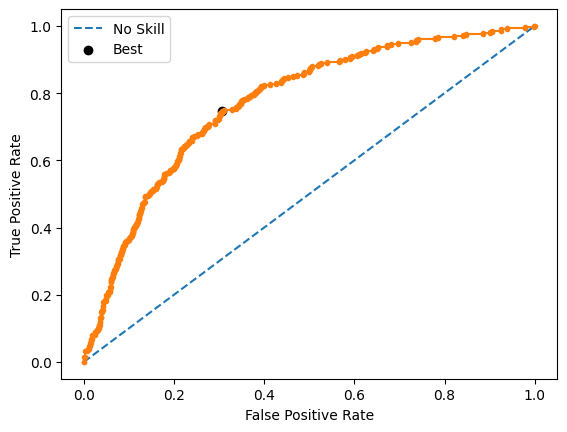

In [397]:
# predict probabilities
yhat0 = model_0.predict(X_test)

# keep probabilities for the positive outcome only
yhat0 = yhat0[:, 0]

# calculate roc curves
fpr, tpr, thresholds0 = roc_curve(y_test, yhat0)

# calculate the g-mean for each threshold
gmeans0 = np.sqrt(tpr * (1 - fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans0)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds0[ix], gmeans0[ix]))

# plot the roc curve for the model
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# show the plot
plt.show()

Now to predict the results using the best value from the AUC ROC curve above



In [398]:
# Predicting the results using best value as a threshold
y_pred_e0 = model_0.predict(X_test)
y_pred_e0 = y_pred_e0 > thresholds0[ix]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


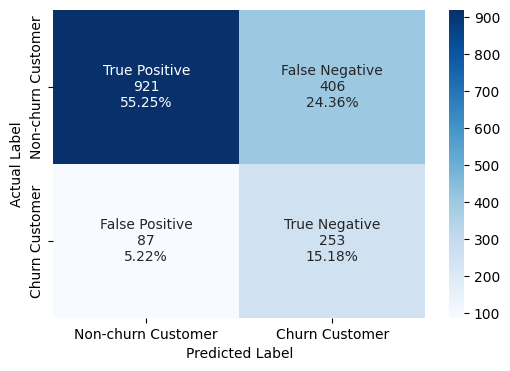

In [399]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e0)

In [400]:
#classification report
cr=classification_report(y_test,y_pred_e0)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1327
           1       0.38      0.74      0.51       340

    accuracy                           0.70      1667
   macro avg       0.65      0.72      0.65      1667
weighted avg       0.81      0.70      0.73      1667



### Yikes! The situation did not improve

* False Negatives got even worse FN_before = 2.32 % to FN_now = 24.36%
* Accruacy on the test set (via the Classification Report) decreased.
* Recall and F1 Scores improved though. 

---
---

## Model - Neural Network with Adam Optimizer

This second model uses an Adam Optimizer to see if I can improve model performance using an alternate optimizer.

It has input, output, and a single hidden layer. 

It uses a AdAptive Moment Estimation (Adam) optimizer and a minimal number of nodes. 

Post trainng on the data, I will use Area Under the Receiver-Operating Characteris (ROC) Curve (AUC) to find the best threshold with this model.

In [401]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [402]:
#Initializing the neural network
model_1 = Sequential()
#Complete the code to add a input layer (specify the # of neurons and activation function)
model_1.add(Dense(128,activation='relu',input_dim = X_train.shape[1]))
#Complete the code to add a hidden layer (specify the # of neurons and activation function)
model_1.add(Dense(64,activation='tanh'))
#Complete the code to add a output layer with the required number of neurons and relu as activation function
model_1.add(Dense(1, activation = 'sigmoid'))

In [403]:
#Complete the code to use Adam as the optimizer.
optimizer = tf.keras.optimizers.Adam()
# uncomment one of the following lines to define the metric to be used
# metric = 'accuracy'
metric = keras.metrics.Recall()
# metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

#metrics = [metrics.BinaryAccuracy(), metrics.Recall()]
metrics1 = [metrics.BinaryAccuracy(), metric]

In [404]:
# Complete the code to compile the model with binary cross entropy as loss function and recall as the metric
model_1.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics1)

In [405]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,857 (38.50 KB)

 Trainable params: 9,857 (38.50 KB)

 Non-trainable params: 0 (0.00 B)

In [406]:
#Fitting the ANN
start = time.time()
history_1 = model_1.fit(
    X_train,y_train,
    batch_size=batch_size, ## Complete the code to specify the batch size to use
    validation_data=(X_val,y_val),
    epochs=epochs, ## Complete the code to specify the number of epochs
    verbose=1
)
end=time.time()

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 978us/step - binary_accuracy: 0.8126 - loss: 0.4343 - recall: 0.2058 - val_binary_accuracy: 0.8215 - val_loss: 0.4292 - val_recall: 0.1873
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - binary_accuracy: 0.8301 - loss: 0.4023 - recall: 0.3154 - val_binary_accuracy: 0.8330 - val_loss: 0.4112 - val_recall: 0.2403
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - binary_accuracy: 0.8397 - loss: 0.3862 - recall: 0.3621 - val_binary_accuracy: 0.8416 - val_loss: 0.3983 - val_recall: 0.2933
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - binary_accuracy: 0.8445 - loss: 0.3734 - recall: 0.3897 - val_binary_accuracy: 0.8395 - val_loss: 0.3883 - val_recall: 0.3216
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - binary_accuracy: 0.8489 - loss: 0.3633 - recall: 0.4187 - val_binary_accuracy: 0.8438 - val_loss: 0.3818 - val_recall: 0.3604
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - binary_accuracy: 0.8534 - loss: 0.

In [407]:
print("Time taken in seconds ",end-start)

Time taken in seconds  5.497386932373047


In [408]:
history_1.history.keys()

dict_keys(['binary_accuracy', 'loss', 'recall', 'val_binary_accuracy', 'val_loss', 'val_recall'])

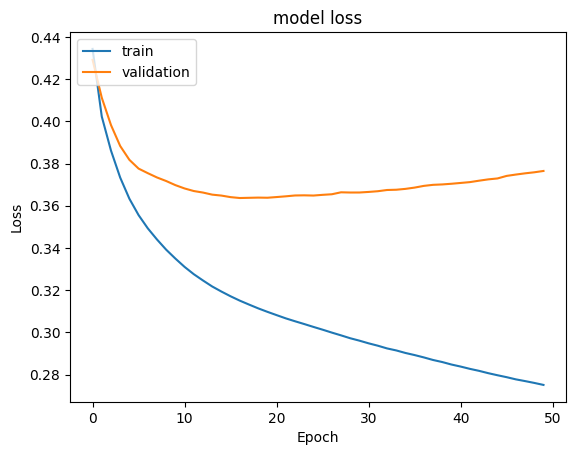

In [409]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### Observation
There is overfitting here with the Adam optimizer. 

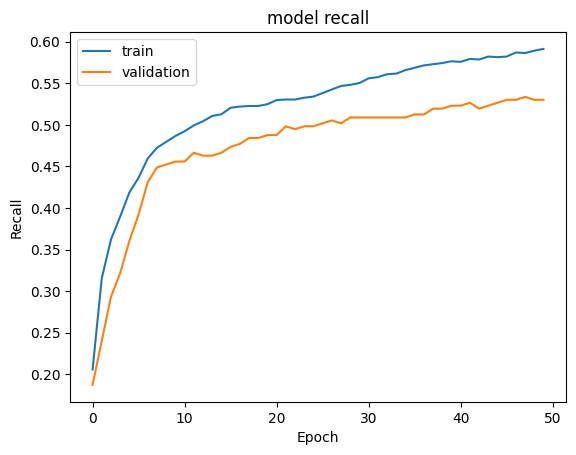

In [410]:
#Plotting Train recall vs Validation recall
plt.plot(history_1.history["recall"])
plt.plot(history_1.history['val_recall'])
plt.title("model recall")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### Observation of the Loss Plots
There is overfitting here with the Adam optimizer. 

In [411]:
#Predicting the TRAIN results using 0.5 as the threshold
y_train_pred = model_1.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step


array([[False],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [False]], shape=(6944, 1))

In [412]:
#Predicting the Validation results using 0.5 as the threshold
y_val_pred = model_1.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(1389, 1))

In [413]:
#Predicting the Testresults using 0.5 as the threshold
y_test_pred = model_1.predict(X_test)
y_test_pred = (y_test_pred > 0.5)
y_test_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 250us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]], shape=(1667, 1))

In [414]:
model_name = "NN with Adam"

train_metric_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

In [415]:
#classification report - Train
cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      5530
           1       0.77      0.65      0.71      1414

    accuracy                           0.89      6944
   macro avg       0.84      0.80      0.82      6944
weighted avg       0.89      0.89      0.89      6944



In [416]:
#classification report - Validation
cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1106
           1       0.64      0.53      0.58       283

    accuracy                           0.84      1389
   macro avg       0.76      0.73      0.74      1389
weighted avg       0.83      0.84      0.84      1389



In [417]:
#classification report - Test
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1327
           1       0.65      0.55      0.60       340

    accuracy                           0.85      1667
   macro avg       0.77      0.74      0.75      1667
weighted avg       0.84      0.85      0.84      1667



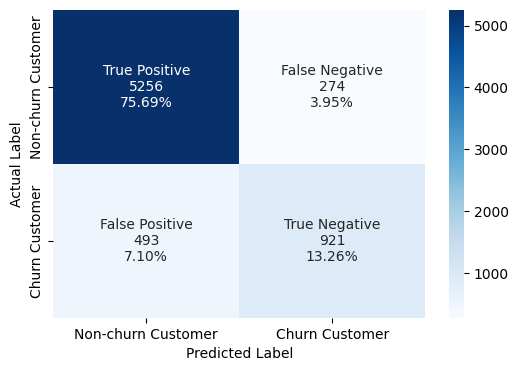

In [418]:
# Calculating the confusion matrix - TRAIN set
make_confusion_matrix(y_train, y_train_pred)

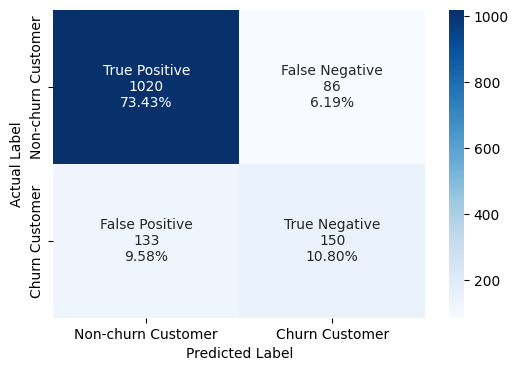

In [419]:
# Calculating the confusion matrix - Validation set
make_confusion_matrix(y_val, y_val_pred)

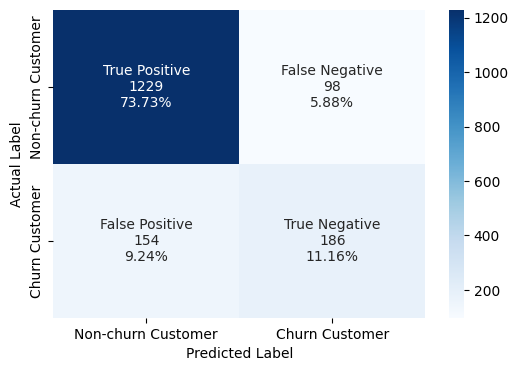

In [420]:
# Calculating the confusion matrix - TEST set
make_confusion_matrix(y_test, y_test_pred)

### Current observations

#### Observation of the Loss pLots
There is overfitting here with the Adam optimizer. 

#### Observation of Classification Reports

* The accuracy has imporved with  Adam usage
* the recall and F1-scores have also improved


In short, predicting churning customers for this model is better, but the over fitting is a concern. 

I will apply the ROC operations as bebore and see if tuning helps even more.


### Tuning the threshold parameter `y_val_pred` using AUC ROC Curve

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
Best Threshold=0.229749, G-Mean=0.764


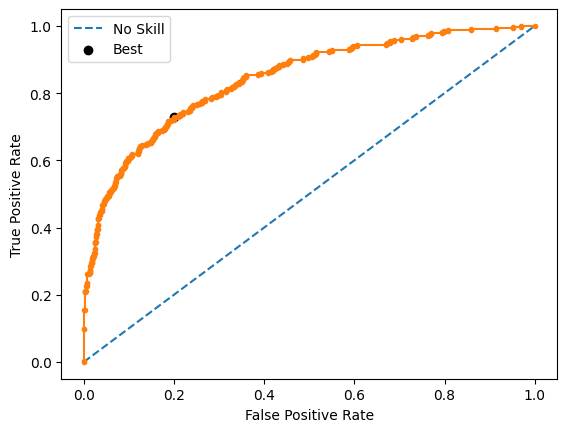

In [421]:
# predict probabilities
yhat1 = model_1.predict(X_test)

# keep probabilities for the positive outcome only
yhat1 = yhat1[:, 0]

# calculate roc curves
fpr, tpr, thresholds1 = roc_curve(y_test, yhat1)

# calculate the g-mean for each threshold
gmeans1 = np.sqrt(tpr * (1 - fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds1[ix], gmeans1[ix]))

# plot the roc curve for the model
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# show the plot
plt.show()

In [422]:
# Predicting the results using best value as a threshold
y_pred_e1 = model_1.predict(X_test)
y_pred_e1 = y_pred_e1 > thresholds1[ix]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


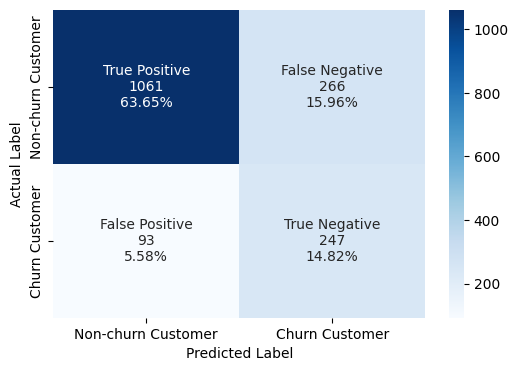

In [423]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e1)

In [424]:
#classification report
cr=classification_report(y_test,y_pred_e1)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1327
           1       0.48      0.73      0.58       340

    accuracy                           0.78      1667
   macro avg       0.70      0.76      0.72      1667
weighted avg       0.83      0.78      0.80      1667



### The situation improve from the simple SGD optimizer

* False Negatives got less worse FN_before = 24.36 % to FN_now = 15.96%
* Accruacy, Recall, and F1 Scores  on the test set (via the Classification Report) decreased after AUC ROC threshold usage.


This new model is a little better, but more improvements can be made

---
---
## Model - Neural Network with Adam Optimizer and Dropout 

With this model, we'll introduce dropout to ensure all the nodes are trained, and we'll also add some complexity with additional layers. We'll stick with the Adam optimizer and same model (i.e., layer design)

Dropout in neural networks is a regularization technique used to prevent overfitting by randomly turning off a fraction of the neurons during training.

In [425]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [426]:
# defining the dropout ratio
# 0.2 means 20% of the neurons will be switched off
dropout_rate = 0.2

In [427]:
#Initializing the neural network
model_2 = Sequential()
#Adding the input layer with 32 neurons and relu as activation function
model_2.add(Dense(32,activation='relu',input_dim = X_train.shape[1]))
# Complete the code to add dropout with ratio of 0.2 or any suitable value.
model_2.add(Dropout(dropout_rate))
# Complete the code to add a hidden layer (specify the # of neurons and the activation function)
model_2.add(Dense(64,activation='tanh'))
# Complete the code to add a hidden layer (specify the # of neurons and the activation function)
model_2.add(Dense(128,activation='relu'))
# Complete the code to add dropout with ratio of 0.1 or any suitable value.
model_2.add(Dropout(dropout_rate))
# Complete the code to add a hidden layer (specify the # of neurons and the activation function)
model_2.add(Dense(64,activation='tanh'))
# Complete the code to add the number of neurons required in the output layer.
model_2.add(Dense(1, activation = 'sigmoid'))

In [428]:
#Complete the code to use Adam as the optimizer.
optimizer = tf.keras.optimizers.Adam()
# uncomment one of the following lines to define the metric to be used
# metric = 'accuracy'
metric = keras.metrics.Recall()
# metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

#metrics = [metrics.BinaryAccuracy(), metrics.Recall()]
metrics2 = ['binary_accuracy', metric]

In [429]:
## Complete the code to compile the model with binary cross entropy as loss function and recall as the metric.
model_2.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=metrics2)

In [430]:
# Summary of the model
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,137 (74.75 KB)

 Trainable params: 19,137 (74.75 KB)

 Non-trainable params: 0 (0.00 B)

In [431]:
#Fitting the ANN with batch_size = 32 and 100 epochs
start = time.time()
history_2 = model_2.fit(
    X_train,y_train,
    batch_size=32,  ##Complete the code to specify the batch size.
    epochs=100, ##Complete the code to specify the # of epochs.
    verbose=1,
    validation_data=(X_val,y_val))
end=time.time()

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7959 - loss: 0.4573 - recall: 0.1202 - val_binary_accuracy: 0.8128 - val_loss: 0.4413 - val_recall: 0.1590
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - binary_accuracy: 0.8092 - loss: 0.4298 - recall: 0.2008 - val_binary_accuracy: 0.8222 - val_loss: 0.4320 - val_recall: 0.1908
Epoch 3/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - binary_accuracy: 0.8221 - loss: 0.4165 - recall: 0.2751 - val_binary_accuracy: 0.8236 - val_loss: 0.4300 - val_recall: 0.2580
Epoch 4/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - binary_accuracy: 0.8286 - loss: 0.4077 - recall: 0.3253 - val_binary_accuracy: 0.8308 - val_loss: 0.4111 - val_recall: 0.2933
Epoch 5/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - binary_accuracy: 0.8324 - loss: 0.3959 - recall: 0.3451 - val_binary_accuracy: 0.8351 - val_loss: 0.4093 - val_recall: 0.3180
Epoch 6/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - binary_accuracy: 0.8327 - loss

In [432]:
print("Time taken in seconds ",end-start)

Time taken in seconds  12.589581966400146


In [433]:
history_2.history.keys()

dict_keys(['binary_accuracy', 'loss', 'recall', 'val_binary_accuracy', 'val_loss', 'val_recall'])

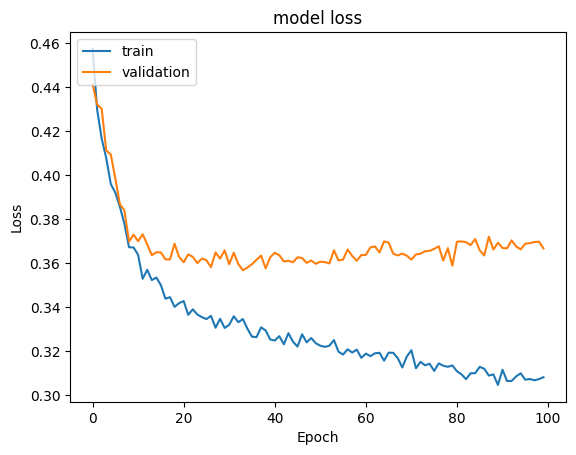

In [434]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_2.history["loss"])
plt.plot(history_2.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

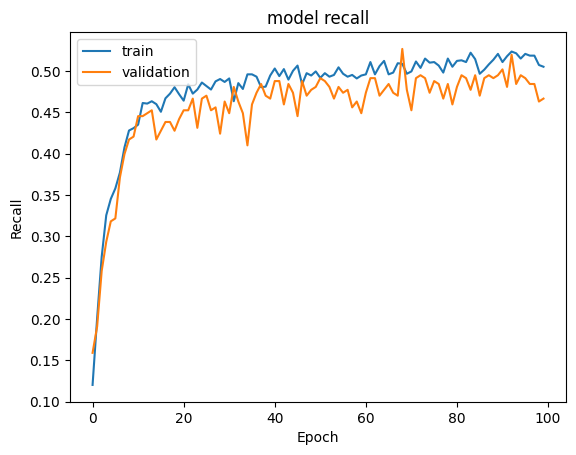

In [435]:
#Plotting Train recall vs Validation recall
plt.plot(history_2.history["recall"])
plt.plot(history_2.history['val_recall'])
plt.title("model recall")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [436]:
#Predicting the TRAIN results using 0.5 as the threshold
y_train_pred = model_2.predict(X_train)
y_train_pred = (y_train_pred > 0.5)
y_train_pred

217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 211us/step


array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(6944, 1))

In [437]:
#Predicting the Validate results using 0.5 as the threshold
y_val_pred = model_2.predict(X_val)
y_val_pred = (y_val_pred > 0.5)
y_val_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(1389, 1))

In [438]:
#Predicting the TEST results using 0.5 as the threshold
y_test_pred = model_2.predict(X_test)
y_test_pred = (y_test_pred > 0.5)
y_test_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]], shape=(1667, 1))

In [439]:
model_name = "NN with Adam & Dropout"

train_metric_df.loc[model_name] = recall_score(y_train,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

In [440]:
#classification report - Train
cr = classification_report(y_train, y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5530
           1       0.84      0.55      0.67      1414

    accuracy                           0.89      6944
   macro avg       0.87      0.76      0.80      6944
weighted avg       0.88      0.89      0.88      6944



In [441]:
#classification report - Validate
cr = classification_report(y_val, y_val_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1106
           1       0.72      0.47      0.57       283

    accuracy                           0.85      1389
   macro avg       0.80      0.71      0.74      1389
weighted avg       0.84      0.85      0.84      1389



In [442]:
#classification report - Test
cr = classification_report(y_test, y_test_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1327
           1       0.72      0.48      0.58       340

    accuracy                           0.86      1667
   macro avg       0.80      0.72      0.75      1667
weighted avg       0.85      0.86      0.85      1667



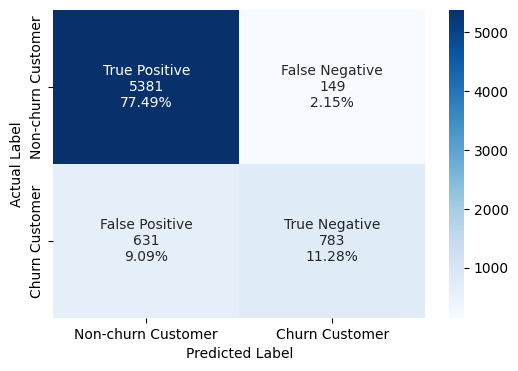

In [443]:
# Calculating the confusion matrix - TRAIN set
make_confusion_matrix(y_train, y_train_pred)

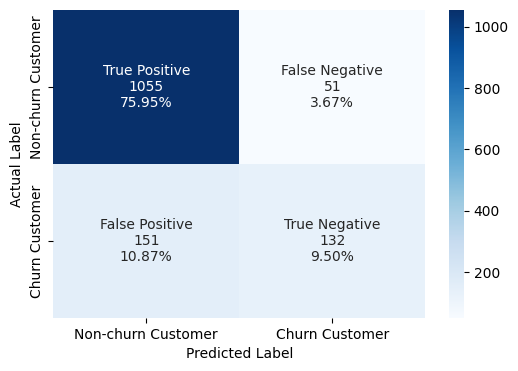

In [444]:
# Calculating the confusion matrix - VALIDATE set
make_confusion_matrix(y_val, y_val_pred)

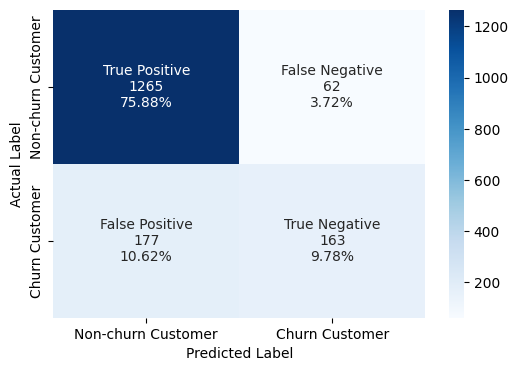

In [445]:
# Calculating the confusion matrix - TEST set
make_confusion_matrix(y_test, y_test_pred)

### Current observations

#### Observation of the Loss pLots
The validation loss curves show overfitting still

#### Observation of Classification Reports

* The accuracy has imporved with Adam usage and Dropout
* the recall and F1-scores have also improved


In short, predicting churning customers for this model is better, but the over fitting is a concern. 

I will apply the ROC operations as bebore and see if tuning helps even more.

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
Best Threshold=0.261499, G-Mean=0.767


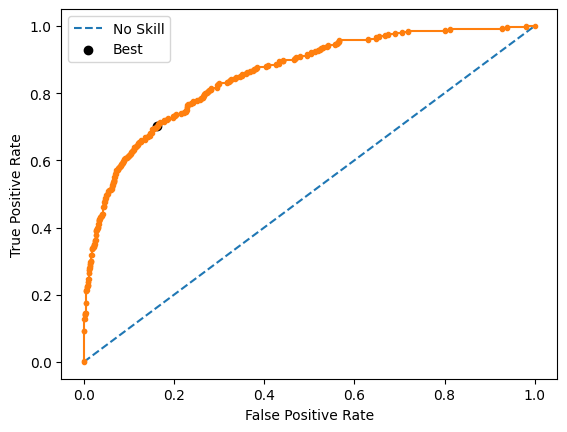

In [446]:
# predict probabilities
yhat2 = model_2.predict(X_test)

# keep probabilities for the positive outcome only
yhat2 = yhat2[:, 0]

# calculate roc curves
fpr, tpr, thresholds2 = roc_curve(y_test, yhat2)

# calculate the g-mean for each threshold
gmeans2 = np.sqrt(tpr * (1 - fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans1)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds2[ix], gmeans2[ix]))

# plot the roc curve for the model
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# show the plot
plt.show()

In [447]:
# Predicting the results using best value as a threshold
y_pred_e2 = model_2.predict(X_test)
y_pred_e2 = y_pred_e2 > thresholds2[ix]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


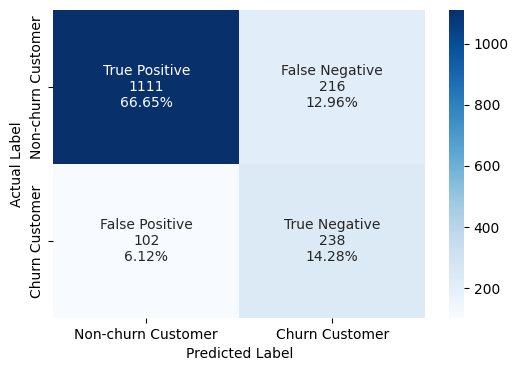

In [448]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e2)

In [449]:
#classification report
cr=classification_report(y_test,y_pred_e2)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.84      0.87      1327
           1       0.52      0.70      0.60       340

    accuracy                           0.81      1667
   macro avg       0.72      0.77      0.74      1667
weighted avg       0.84      0.81      0.82      1667



### Droput with the Adam Optimizer

* False Negatives got less worse FN_before = 15.96 % to FN_now = 13.50%
* Accruacy, Recall, and F1 Scores  on the test set (via the Classification Report) decreased after AUC ROC threshold usage.


This new model is a little better, but more improvements can still be made especially as we saw overfiting in the loss and training curves.

---
---
## Model - Neural Network with Balanced Data (Applying SMOTE) - Using SGD 

So far, I have been exploring various models and parameters with the full knowledge that the data is not at all balanced, and that churning customers are substantially under-represented in the data set. 

In the next set of models, I am to cure the imbalance issue.  I use the **Synthetic Minority Over-sampling Technique (SMOTE)** to balance the data, and then re-run our grid search exploration for hyperparamter tuning.


In [450]:
sm  = SMOTE(random_state=42)

#Complete the code to fit SMOTE on the training data.
X_train_smote, y_train_smote= sm.fit_resample(X_train, y_train)
print('After UpSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

After UpSampling, the shape of train_X: (11060, 11)
After UpSampling, the shape of train_y: (11060,) 



Let's build a model with the balanced dataset

In [451]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [452]:
#Initializing the model
model_3 = Sequential()
#Complete the code to add a input layer (specify the # of neurons and activation function)
model_3.add(Dense(128,activation='relu',input_dim = X_train_smote.shape[1]))
#Complete the code to add a hidden layer (specify the # of neurons and activation function)
model_3.add(Dense(64,activation='relu'))
#Complete the code to add a hidden layer (specify the # of neurons and activation function)
model_3.add(Dense(32,activation='relu'))
# Complete the code to add the required number of neurons in the output layer with a sigmoid activation function.
model_3.add(Dense(1, activation = 'sigmoid'))

In [453]:
#Complete the code to use Adam as the optimizer.
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
# uncomment one of the following lines to define the metric to be used
# metric = 'accuracy'
metric = keras.metrics.Recall()
# metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

#metrics = [metrics.BinaryAccuracy(), metrics.Recall()]
metrics3 = ['binary_accuracy', metric]

In [454]:
# Complete the code to compile the model with binary cross entropy as loss function and recall as the metric
model_3.compile(loss=BinaryCrossentropy(), optimizer=optimizer, metrics=metrics3)

In [455]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 0 (0.00 B)

In [456]:
#Fitting the ANN
start = time.time()
history_3 = model_3.fit(
    X_train_smote, y_train_smote,
    batch_size=batch_size, ## Complete the code to specify the batch size to use
    epochs=100, ## Complete the code to specify the number of epochs
    verbose=1,
    validation_data = (X_val,y_val)
)
end=time.time()

Epoch 1/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - binary_accuracy: 0.5108 - loss: 0.6992 - recall: 0.1045 - val_binary_accuracy: 0.7372 - val_loss: 0.6709 - val_recall: 0.1484
Epoch 2/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - binary_accuracy: 0.5363 - loss: 0.6931 - recall: 0.1835 - val_binary_accuracy: 0.7163 - val_loss: 0.6713 - val_recall: 0.1908
Epoch 3/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - binary_accuracy: 0.5717 - loss: 0.6876 - recall: 0.2828 - val_binary_accuracy: 0.7163 - val_loss: 0.6697 - val_recall: 0.3074
Epoch 4/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - binary_accuracy: 0.6028 - loss: 0.6823 - recall: 0.3660 - val_binary_accuracy: 0.7120 - val_loss: 0.6668 - val_recall: 0.3675
Epoch 5/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - binary_accuracy: 0.6315 - loss: 0.6769 - recall: 0.4400 - val_binary_accuracy: 0.7207 - val_loss: 0.6629 - val_recall: 0.4346
Epoch 6/100
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - binary_accuracy: 0.6510 - lo

In [457]:
print("Time taken in seconds ",end-start)

Time taken in seconds  14.00526213645935


In [458]:
history_3.history.keys()

dict_keys(['binary_accuracy', 'loss', 'recall', 'val_binary_accuracy', 'val_loss', 'val_recall'])

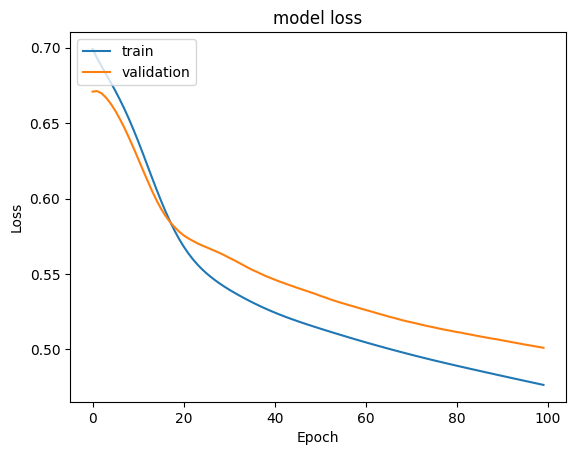

In [459]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_3.history["loss"])
plt.plot(history_3.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

The curve shows overfitting.

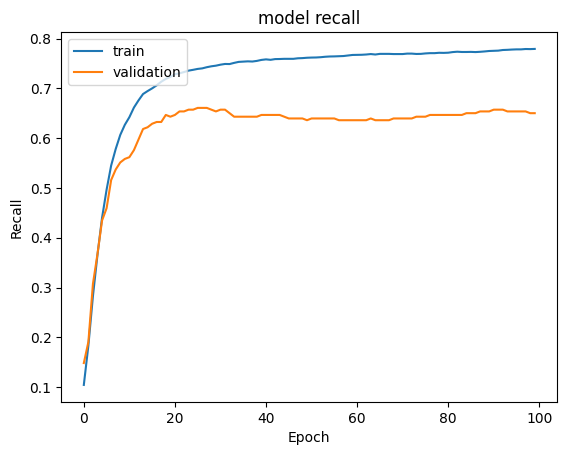

In [460]:
#Plotting Train recall vs Validation recall
plt.plot(history_3.history["recall"])
plt.plot(history_3.history['val_recall'])
plt.title("model recall")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [461]:
y_train_pred = model_3.predict(X_train_smote)
#Predicting the results using 0.5 as the threshold
y_train_pred = (y_train_pred > 0.5)
y_train_pred

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]], shape=(11060, 1))

In [462]:
y_val_pred = model_3.predict(X_val)
#Predicting the results using 0.5 as the threshold
y_val_pred = (y_val_pred > 0.5)
y_val_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


array([[ True],
       [ True],
       [False],
       ...,
       [False],
       [ True],
       [False]], shape=(1389, 1))

In [463]:
y_test_pred = model_3.predict(X_test)
#Predicting the results using 0.5 as the threshold
y_test_pred = (y_test_pred > 0.5)
y_test_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [ True],
       [False]], shape=(1667, 1))

In [464]:
model_name = "NN with SMOTE & SGD"

train_metric_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

In [465]:
cr=classification_report(y_train_smote,y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5530
           1       0.78      0.78      0.78      5530

    accuracy                           0.78     11060
   macro avg       0.78      0.78      0.78     11060
weighted avg       0.78      0.78      0.78     11060



In [466]:
cr=classification_report(y_val, y_val_pred) ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1106
           1       0.43      0.65      0.52       283

    accuracy                           0.75      1389
   macro avg       0.66      0.71      0.68      1389
weighted avg       0.80      0.75      0.77      1389



In [467]:
cr=classification_report(y_test, y_test_pred) ## Complete the code to check the model's performance on the test set
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1327
           1       0.42      0.66      0.52       340

    accuracy                           0.75      1667
   macro avg       0.66      0.72      0.67      1667
weighted avg       0.80      0.75      0.76      1667



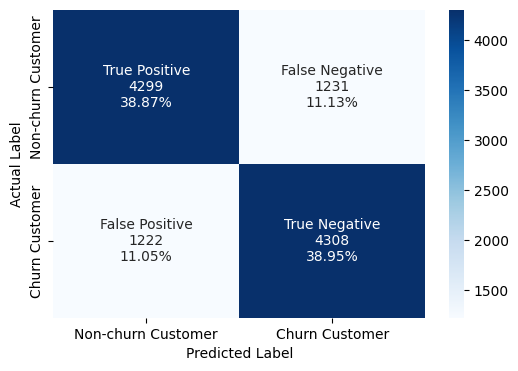

In [468]:
#Calculating the confusion matrix
make_confusion_matrix(y_train_smote, y_train_pred)

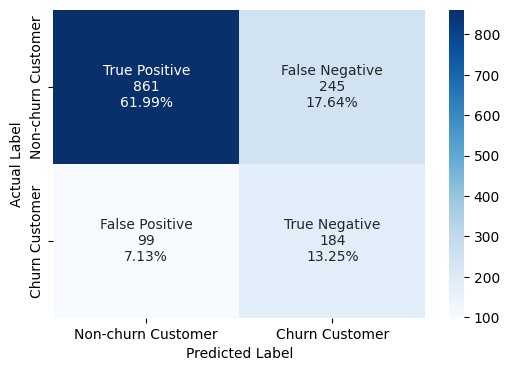

In [469]:
#Calculating the confusion matrix
make_confusion_matrix(y_val, y_val_pred)

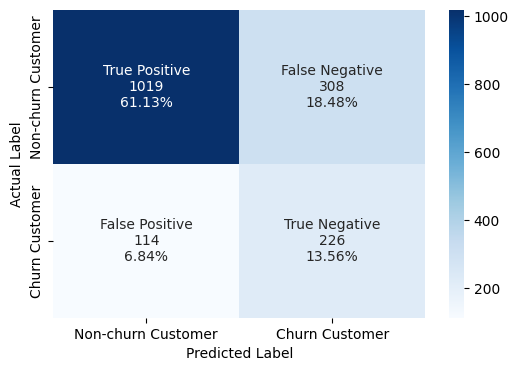

In [470]:
#Calculating the confusion matrix
make_confusion_matrix(y_test, y_test_pred)

### Current observations

#### Observation of the Loss pLots
The validation loss curves show overfitting still

#### Observation of Classification Reports

* The accuracy, recall, and F1-scores are not showing an improvement

I will apply the ROC operations as bebore and see if tuning helps even more.

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
Best Threshold=0.449169, G-Mean=0.729


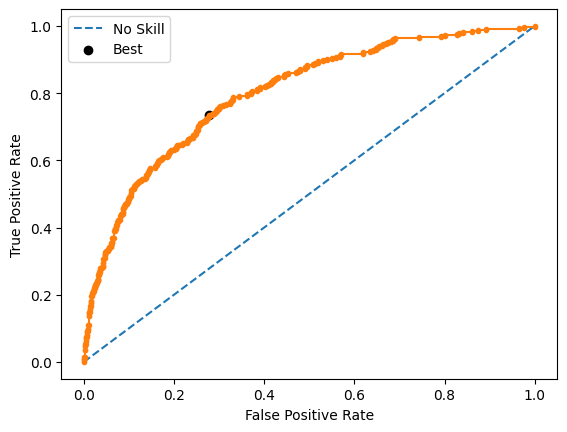

In [471]:
# predict probabilities
yhat3 = model_3.predict(X_test)

# keep probabilities for the positive outcome only
yhat3 = yhat3[:, 0]

# calculate roc curves
fpr, tpr, thresholds3 = roc_curve(y_test, yhat3)

# calculate the g-mean for each threshold
gmeans3 = np.sqrt(tpr * (1 - fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans3)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds3[ix], gmeans3[ix]))

# plot the roc curve for the model
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# show the plot
plt.show()

In [472]:
# Predicting the results using best value as a threshold
y_pred_e3 = model_3.predict(X_test)
y_pred_e3 = y_pred_e3 > thresholds3[ix]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


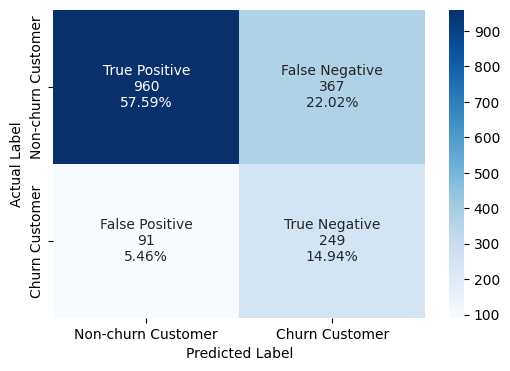

In [473]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e3)

In [474]:
#classification report
cr=classification_report(y_test,y_pred_e3)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1327
           1       0.40      0.73      0.52       340

    accuracy                           0.73      1667
   macro avg       0.66      0.73      0.66      1667
weighted avg       0.81      0.73      0.75      1667



### Results - Neural Network with Balanced Data (Applying SMOTE) - Using SGD 

* False Negatives got FN_before = 13.50 % to FN_now with SMOT and SGD = 22.02%
* Accruacy, Recall, and F1 Scores  on the test set (via the Classification Report) decreased after AUC ROC threshold usage.


This new model is a not an improvement.

---
---
## Model - Neural Network with Balanced Data (Applying SMOTE) - Using ADAM

Let's build a model with the balanced dataset

In [475]:
	
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [476]:
sm  = SMOTE(random_state=42)

#Complete the code to fit SMOTE on the training data.
X_train_smote, y_train_smote= sm.fit_resample(X_train, y_train)
print('After UpSampling, the shape of train_X: {}'.format(X_train_smote.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

After UpSampling, the shape of train_X: (11060, 11)
After UpSampling, the shape of train_y: (11060,) 



In [477]:
#Initializing the model
model_4 = Sequential()
#Complete the code to add a input layer (specify the # of neurons and activation function)
model_4.add(Dense(128,activation='relu',input_dim = X_train_smote.shape[1]))
#Complete the code to add a hidden layer (specify the # of neurons and activation function)
model_4.add(Dense(128,activation='tanh'))
#Complete the code to add a hidden layer (specify the # of neurons and activation function)
model_4.add(Dense(64,activation='relu'))
# Complete the code to add the required number of neurons in the output layer and a suitable activation function.
model_4.add(Dense(1, activation = 'sigmoid'))

In [478]:
#Complete the code to use Adam as the optimizer.
optimizer = tf.keras.optimizers.Adam()
# uncomment one of the following lines to define the metric to be used
# metric = 'accuracy'
metric = keras.metrics.Recall()
# metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

metrics4 = ["accuracy", metric]

In [479]:
# Complete the code to compile the model with binary cross entropy as loss function and recall as the metric
model_4.compile(loss=BinaryCrossentropy(),optimizer=optimizer,metrics=metrics4)

In [480]:
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,369 (103.00 KB)

 Trainable params: 26,369 (103.00 KB)

 Non-trainable params: 0 (0.00 B)

In [481]:
#Fitting the ANN
start = time.time()
history_4 = model_4.fit(
    X_train_smote,y_train_smote,
    batch_size=64, ## Complete the code to specify the batch size to use
    epochs=epochs,  ## Complete the code to specify the number of epochs
    verbose=1,
    validation_data = (X_val,y_val)
)
end=time.time()

Epoch 1/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7388 - loss: 0.5315 - recall: 0.7331 - val_accuracy: 0.6955 - val_loss: 0.6065 - val_recall: 0.7703
Epoch 2/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.7750 - loss: 0.4702 - recall: 0.7676 - val_accuracy: 0.7250 - val_loss: 0.5536 - val_recall: 0.7951
Epoch 3/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.7953 - loss: 0.4361 - recall: 0.7904 - val_accuracy: 0.7466 - val_loss: 0.5218 - val_recall: 0.7915
Epoch 4/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.8090 - loss: 0.4153 - recall: 0.8060 - val_accuracy: 0.7567 - val_loss: 0.5055 - val_recall: 0.7845
Epoch 5/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.8154 - loss: 0.4027 - recall: 0.8154 - val_accuracy: 0.7631 - val_loss: 0.4899 - val_recall: 0.7668
Epoch 6/50
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.8201 - loss: 0.3937 - recall: 0.8219 - val_accuracy: 0.7725 - val_loss: 0.4848 - val_recall: 0

In [482]:
print("Time taken in seconds ",end-start)

Time taken in seconds  6.049911022186279


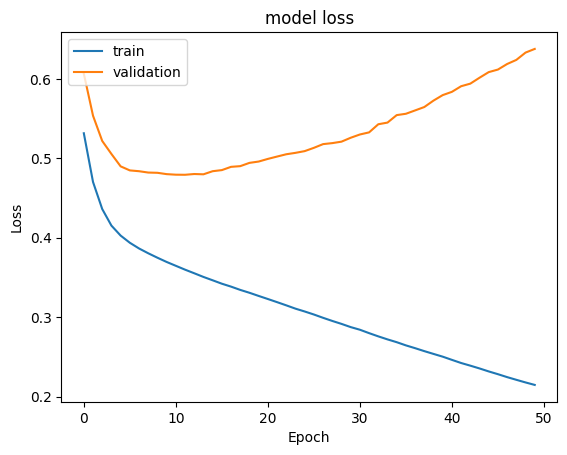

In [483]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_4.history["loss"])
plt.plot(history_4.history["val_loss"])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [484]:
history_4.history.keys()

dict_keys(['accuracy', 'loss', 'recall', 'val_accuracy', 'val_loss', 'val_recall'])

#### Observation: The Overfitting is immense.


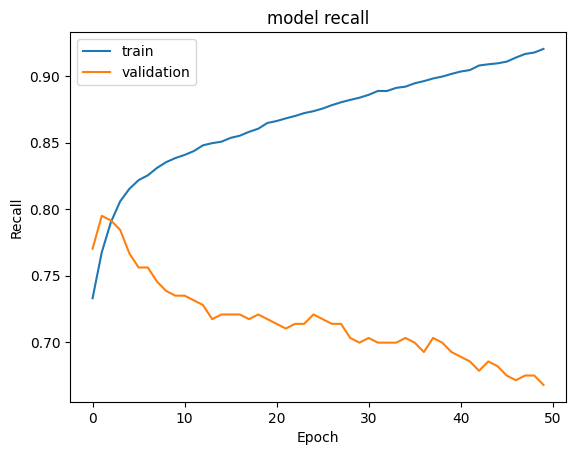

In [485]:
#Plotting Train recall vs Validation recall
plt.plot(history_4.history["recall"])
plt.plot(history_4.history["val_recall"])
plt.title("model recall")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [486]:
y_train_pred = model_4.predict(X_train_smote)
#Predicting the results using 0.5 as the threshold
y_train_pred = (y_train_pred > 0.5)
y_train_pred

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step


array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]], shape=(11060, 1))

In [487]:
y_val_pred = model_4.predict(X_val)
#Predicting the results using 0.5 as the threshold
y_val_pred = (y_val_pred > 0.5)
y_val_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


array([[ True],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(1389, 1))

In [488]:
y_test_pred = model_4.predict(X_test)
#Predicting the results using 0.5 as the threshold
y_test_pred = (y_test_pred > 0.5)
y_test_pred

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]], shape=(1667, 1))

In [489]:
model_name = "NN with SMOTE & Adam"

train_metric_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

In [490]:
cr=classification_report(y_train_smote,y_train_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5530
           1       0.88      0.94      0.91      5530

    accuracy                           0.91     11060
   macro avg       0.91      0.91      0.91     11060
weighted avg       0.91      0.91      0.91     11060



In [491]:
cr=classification_report(y_val, y_val_pred) ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1106
           1       0.48      0.67      0.56       283

    accuracy                           0.78      1389
   macro avg       0.69      0.74      0.71      1389
weighted avg       0.82      0.78      0.79      1389



In [492]:
cr=classification_report(y_test, y_test_pred) ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.81      0.86      1327
           1       0.47      0.66      0.55       340

    accuracy                           0.78      1667
   macro avg       0.69      0.74      0.70      1667
weighted avg       0.82      0.78      0.79      1667



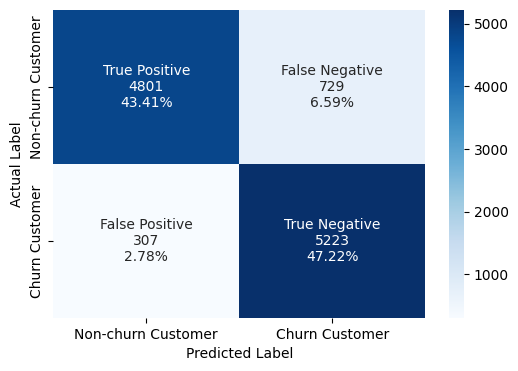

In [493]:
#Calculating the confusion matrix
make_confusion_matrix(y_train_smote, y_train_pred)

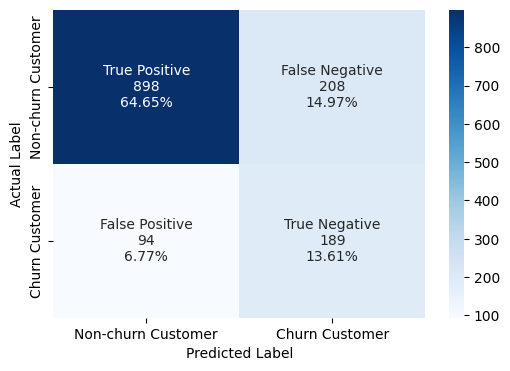

In [494]:
#Calculating the confusion matrix
make_confusion_matrix(y_val, y_val_pred)  ## Complete the code to check the model's performance on the validation set

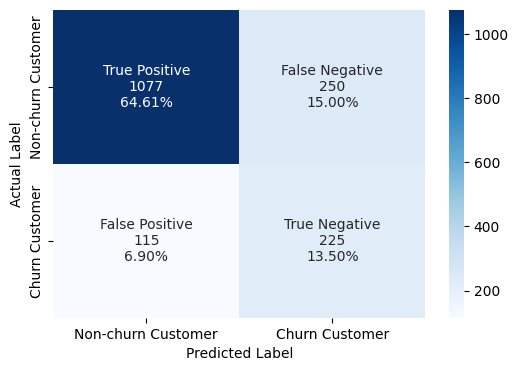

In [495]:
#Calculating the confusion matrix
make_confusion_matrix(y_test, y_test_pred)  ## Complete the code to check the model's performance on the validation set

### Current observations

#### Observation of the Loss PLots
The validation loss curves show extreme overfitting

#### Observation of Classification Reports

* The accuracy, recall, and F1-scores shows vast improvements over the SMOTE & SGD 

I will apply the ROC operations as bebore and see if tuning helps even more.

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
Best Threshold=0.382391, G-Mean=0.739


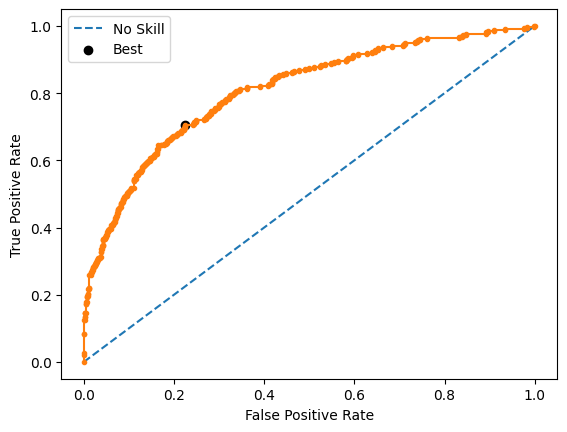

In [496]:
# predict probabilities
yhat4 = model_4.predict(X_test)

# keep probabilities for the positive outcome only
yhat4 = yhat4[:, 0]

# calculate roc curves
fpr, tpr, thresholds4 = roc_curve(y_test, yhat4)

# calculate the g-mean for each threshold
gmeans4 = np.sqrt(tpr * (1 - fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans4)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds4[ix], gmeans4[ix]))

# plot the roc curve for the model
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# show the plot
plt.show()

In [497]:
# Predicting the results using best value as a threshold
y_pred_e4 = model_4.predict(X_test)
y_pred_e4 = y_pred_e4 > thresholds4[ix]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


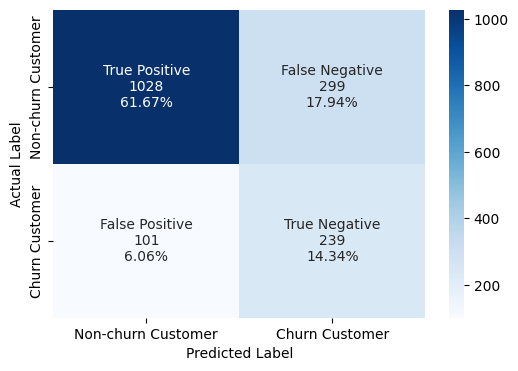

In [498]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e4)

In [499]:
#classification report
cr=classification_report(y_test,y_pred_e4)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.77      0.84      1327
           1       0.44      0.70      0.54       340

    accuracy                           0.76      1667
   macro avg       0.68      0.74      0.69      1667
weighted avg       0.82      0.76      0.78      1667



### Results - Neural Network with Balanced Data (Applying SMOTE) - Using Adam - POST ROC Operations

* False Negatives without ROC optimization are less than with the ROC optimization
* Accruacy, Recall, and F1 Scores  on the test set (via the Classification Report) decreased after AUC ROC threshold usage.


ROC optimization did not help as much I would have thought here. 

Last Model will be to try adding the DROPOUT

---
---
## Model - Neural Network with Balanced Data (Applying SMOTE) - Using ADAM and Including Dropout

Let's build a model with the balanced dataset, but include Droput to see how to mitigate the overfitting.

In [500]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [501]:
#Initializing the model
model_5 = Sequential()
# Complete the code to add required # of neurons to the input layer with relu as activation function
model_5.add(Dense(128,activation='relu',input_dim = X_train_smote.shape[1]))
#Complete the code to add dropout rate
model_5.add(Dropout(0.2))
# Complete the code to add required # neurons to the hidden layer with any activation function.
model_5.add(Dense(64,activation='relu'))
# Complete the code to add dropout rate.
model_5.add(Dropout(0.2))
# Adding hidden layer with 8 neurons with relu as activation function
model_5.add(Dense(8,activation='relu'))
# Complete the code to add the required number of neurons in the output layer with a suitable activation function.
model_5.add(Dense(1, activation = 'sigmoid'))

In [502]:
#Complete the code to use Adam as the optimizer.
optimizer = tf.keras.optimizers.Adam()
# uncomment one of the following lines to define the metric to be used
# metric = 'accuracy'
# metric = keras.metrics.Recall()
# metric = keras.metrics.Precision()
# metric = keras.metrics.F1Score()

metric5 = ['accuracy',metrics.Recall()]

In [503]:
# Complete the code to compile the model with binary cross entropy as loss function and recall as the metric
model_5.compile(loss=BinaryCrossentropy(),optimizer=optimizer,metrics=metric5)

In [504]:
model_5.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,321 (40.32 KB)

 Trainable params: 10,321 (40.32 KB)

 Non-trainable params: 0 (0.00 B)

In [505]:
start = time.time()
history_5 = model_5.fit(
    X_train_smote,y_train_smote,
    batch_size=32, ## Complete the code to specify the batch size to use
    epochs=50, ## Complete the code to specify the number of epochs
    verbose=1,
    validation_data = (X_val,y_val))
end=time.time()

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - accuracy: 0.7148 - loss: 0.5591 - recall: 0.7183 - val_accuracy: 0.6767 - val_loss: 0.5899 - val_recall: 0.6890
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.7546 - loss: 0.5038 - recall: 0.7517 - val_accuracy: 0.7127 - val_loss: 0.5798 - val_recall: 0.7597
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.7721 - loss: 0.4775 - recall: 0.7714 - val_accuracy: 0.7336 - val_loss: 0.5422 - val_recall: 0.7597
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.7848 - loss: 0.4616 - recall: 0.7846 - val_accuracy: 0.7365 - val_loss: 0.5401 - val_recall: 0.7633
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7892 - loss: 0.4481 - recall: 0.7937 - val_accuracy: 0.7451 - val_loss: 0.5191 - val_recall: 0.7703
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7951 - loss: 0.4402 - recall: 0.8020 - val_accuracy: 0.7732 - val_loss: 0.4892 - val_recall:

In [506]:
print("Time taken in seconds ",end-start)

Time taken in seconds  8.611654996871948


In [507]:
history_5.history.keys()

dict_keys(['accuracy', 'loss', 'recall', 'val_accuracy', 'val_loss', 'val_recall'])

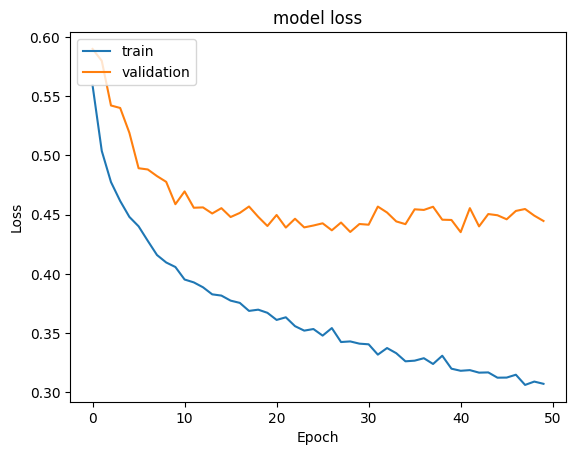

In [508]:
#Plotting Train Loss vs Validation Loss
plt.plot(history_5.history["loss"])
plt.plot(history_5.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

#### Observation


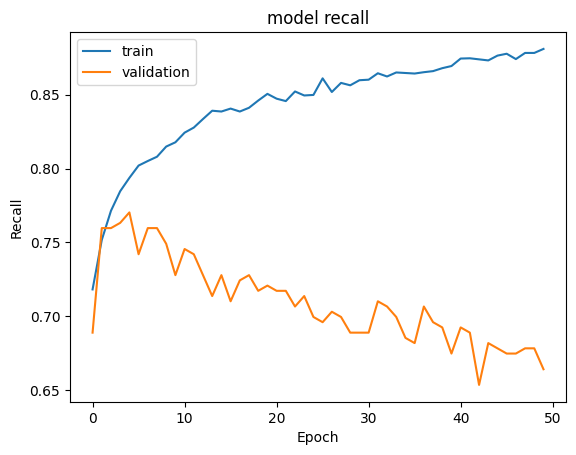

In [509]:
#Plotting Train recall vs Validation recall
plt.plot(history_5.history["recall"])
plt.plot(history_5.history["val_recall"])
plt.title("model recall")
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [510]:
y_train_pred = model_5.predict(X_train_smote)
#Predicting the results using 0.5 as the threshold
y_train_pred = (y_train_pred > 0.5)
y_train_pred

346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step


array([[ True],
       [ True],
       [False],
       ...,
       [ True],
       [ True],
       [ True]], shape=(11060, 1))

In [511]:
y_val_pred = model_5.predict(X_val)
#Predicting the results using 0.5 as the threshold
y_val_pred = (y_val_pred > 0.5)
y_val_pred

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]], shape=(1389, 1))

In [512]:
cr=classification_report(y_test, y_test_pred) ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.81      0.86      1327
           1       0.47      0.66      0.55       340

    accuracy                           0.78      1667
   macro avg       0.69      0.74      0.70      1667
weighted avg       0.82      0.78      0.79      1667



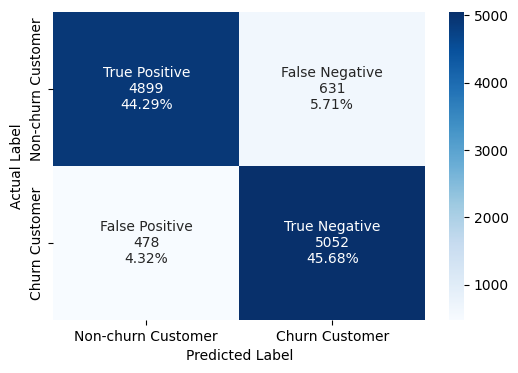

In [513]:
#Calculating the confusion matrix
make_confusion_matrix(y_train_smote, y_train_pred)

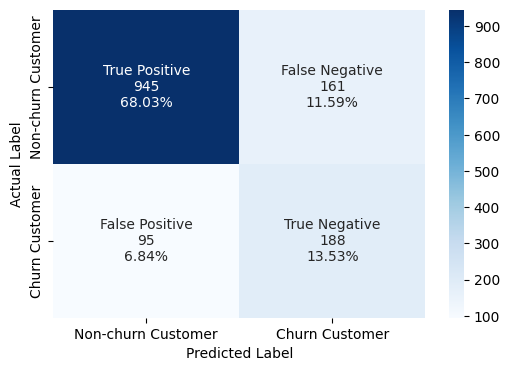

In [514]:
#Calculating the confusion matrix
make_confusion_matrix(y_val, y_val_pred)  ## Complete the code to check the model's performance on the validation set

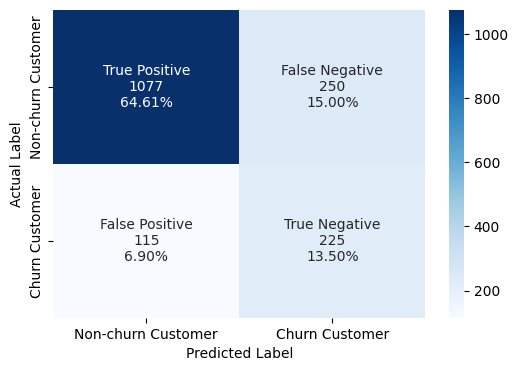

In [515]:
#Calculating the confusion matrix
make_confusion_matrix(y_test, y_test_pred)  ## Complete the code to check the model's performance on the validation set

In [516]:
model_name = "NN with SMOTE,Adam & Dropout"

train_metric_df.loc[model_name] = recall_score(y_train_smote,y_train_pred)
valid_metric_df.loc[model_name] = recall_score(y_val,y_val_pred)

### Current observations

#### Observation of the Loss PLots
The validation loss curves show much less overfitting

#### Observation of Classification Reports

* The accuracy, recall, and F1-scores shows improvements over the SMOTE & ADAM use without dropout 

I will apply the ROC operations as bebore and see if tuning helps even more.

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step
Best Threshold=0.467276, G-Mean=0.765


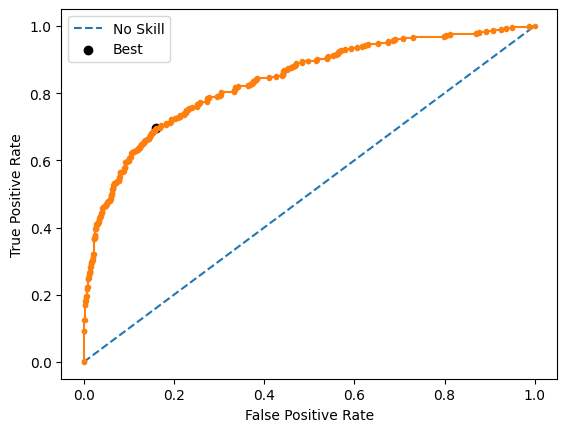

In [517]:
# predict probabilities
yhat5 = model_5.predict(X_test)

# keep probabilities for the positive outcome only
yhat5 = yhat5[:, 0]

# calculate roc curves
fpr, tpr, thresholds5 = roc_curve(y_test, yhat5)

# calculate the g-mean for each threshold
gmeans5 = np.sqrt(tpr * (1 - fpr))

# locate the index of the largest g-mean
ix = np.argmax(gmeans5)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds5[ix], gmeans5[ix]))

# plot the roc curve for the model
plt.plot([0, 1], [0, 1], linestyle="--", label="No Skill")
plt.plot(fpr, tpr, marker=".")
plt.scatter(fpr[ix], tpr[ix], marker="o", color="black", label="Best")

# axis labels
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# show the plot
plt.show()

In [518]:
# Predicting the results using best value as a threshold
y_pred_e5 = model_5.predict(X_test)
y_pred_e5 = y_pred_e5 > thresholds5[ix]

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


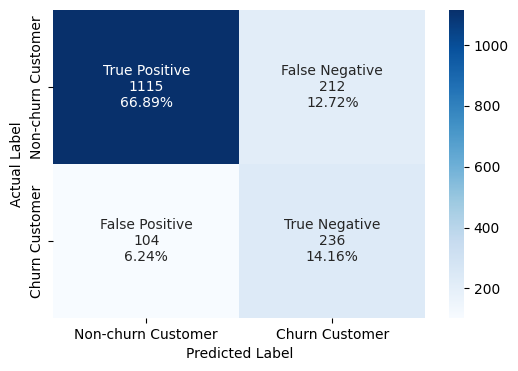

In [519]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e5)

In [520]:
#classification report
cr=classification_report(y_test,y_pred_e5)    ## Complete the code to check the model's performance on the validation set
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1327
           1       0.53      0.69      0.60       340

    accuracy                           0.81      1667
   macro avg       0.72      0.77      0.74      1667
weighted avg       0.84      0.81      0.82      1667



### Results - Neural Network with Balanced Data (Applying SMOTE) - Using Adam and Dropout- POST ROC Operations

* False Negatives with ROC optimization here are less than when ROC optimization is applied
* Accruacy, Recall, and F1 Scores on the test set (via the Classification Report) increased after AUC ROC threshold usage for the SMOTE, ADAM, with Droput


ROC optimization HELPED!

---
---

# Summarizing the Model Results

Comparing the Model Performances and Discussion of the Final Model Selection


In [521]:
print("Training performance comparison")
train_metric_df

Training performance comparison


,recall
NN with SGD,0.168
NN with Adam,0.651
NN with Adam & Dropout,0.554
NN with SMOTE & SGD,0.779
NN with SMOTE & Adam,0.944
"NN with SMOTE,Adam & Dropout",0.914


In [522]:
print("Validation set performance comparison")
valid_metric_df

Validation set performance comparison


,recall
NN with SGD,0.113
NN with Adam,0.530
NN with Adam & Dropout,0.466
NN with SMOTE & SGD,0.650
NN with SMOTE & Adam,0.668
"NN with SMOTE,Adam & Dropout",0.664


In [523]:
train_metric_df - valid_metric_df

,recall
NN with SGD,0.055
NN with Adam,0.121
NN with Adam & Dropout,0.087
NN with SMOTE & SGD,0.129
NN with SMOTE & Adam,0.277
"NN with SMOTE,Adam & Dropout",0.249


#### Observations: 

The best models appear to be the SMOTE & Adam and the SMOTE, ADAM, and DROPOUT

* SMOTE & Adam had better recall results, but suffered from more excessive overfitting than the SMOTE, ADAM, and DROPOUT model.

* In my earlier analysis, by performing AUC ROC optimization of the SMOTE, ADAM, and DROPOUT model. I was able to improve the SMOTE, ADAM, and DROPOUT model such that it performed better than the SMOTE ADAM model.

So, the best model is shown below:

### Best Model to Push to Production


In [524]:
y_pred_e5 = model_5.predict(X_test)
y_pred_e5 = y_pred_e5 > thresholds5[ix]
print(y_pred_e5)

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
[[False]
 [False]
 [False]
 ...
 [ True]
 [ True]
 [False]]


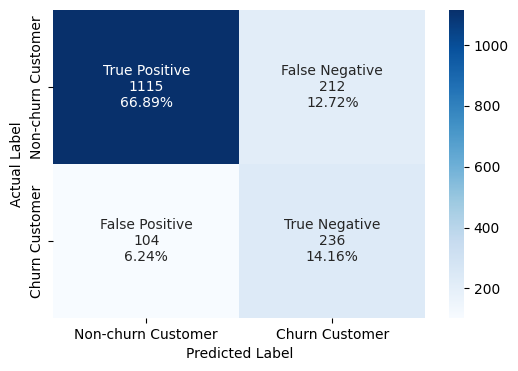

In [525]:
# Calculating the confusion matrix
make_confusion_matrix(y_test, y_pred_e5)

In [527]:
#lets print classification report
cr=classification_report(y_test,y_pred_e5)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      1327
           1       0.53      0.69      0.60       340

    accuracy                           0.81      1667
   macro avg       0.72      0.77      0.74      1667
weighted avg       0.84      0.81      0.82      1667



### Summary - Winning Model Performance Metrics:

False Negatives: 12.72% the smallest among all models tested

Reduced overfitting: Seen in validation loss figures.

Accuracy: The model achieved an accuracy of approximately 81%, indicating that it correctly classified 81% of the instances in the test dataset.

Precision: For predicting churn (class 1), the precision is 53%, implying that when the model predicts churn, it is correct 53% of the time. For non-churn (class 0), the precision is 94%.

Recall: The recall for churn (class 1) is 69%, meaning that the model identified 69% of the actual churn cases correctly. For non-churn (class 0), the recall is 84%.

F1-score: The F1-score, which is the harmonic mean of precision and recall, is 0.60 for churn (class 1) and 0.88 for non-churn (class 0).


---
### Actionable Insights and Business 

#### Business Recommendation

**Precision and Recall Balance:** The model demonstrates a trade-off between precision and recall. While it achieves a high precision for non-churn customers, the precision for churn prediction is relatively lower. However, it manages to capture a significant portion of actual churn cases with a reasonable recall. This indicates that the model can effectively identify potential churners, albeit with some misclassifications.

**Focus on Recall Improvement:** To improve the model's performance further, particularly in identifying churn cases, focus should be placed on improving recall without significantly sacrificing precision. This can be achieved through strategies such as feature engineering, exploring different model architectures, adjusting class weights, or collecting more diverse data.

**Utilizing Predictions for Customer Retention:** Despite its limitations, the model can still provide valuable insights for the bank's customer retention strategies. By leveraging the model predictions, the bank can prioritize efforts towards retaining customers who are predicted to churn, offering tailored incentives, personalized communication, or targeted marketing campaigns to mitigate churn risk.

**Continuous Model Monitoring, Improvement, and Refreshment:** It's essential to continuously monitor the model's performance and retrain it periodically with updated data. As customer behavior evolves over time, the model needs to adapt to capture new patterns and trends accurately. Regular evaluation and refinement of the model will ensure its effectiveness in supporting the bank's customer retention efforts.

**Conclusion:** While Model 5 provides a solid foundation for predicting customer churn, there's room for improvement to enhance its predictive power and applicability in real-world business scenarios. By focusing on refining the model and integrating its predictions into strategic decision-making processes, the bank can proactively address churn risk and foster long-term customer relationships.